In [1]:
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.EEG_Tensorflow_models

  Cloning https://github.com/UN-GCPDS/python-gcpds.EEG_Tensorflow_models to /tmp/pip-req-build-pi31w9w_
  Running command git clone --filter=blob:none --quiet https://github.com/UN-GCPDS/python-gcpds.EEG_Tensorflow_models /tmp/pip-req-build-pi31w9w_
  Resolved https://github.com/UN-GCPDS/python-gcpds.EEG_Tensorflow_models to commit 975885b1f6814fd5958199919b33e02a6a9aa152
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.4/184.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.7/234.7 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 96.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Lambda, Reshape, Conv2DTranspose, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models, initializers,regularizers
from tensorflow.keras.losses import binary_crossentropy
# from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from keras.losses import MeanSquaredError
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib as mpl
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

from matplotlib import cm
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tensorflow.keras.losses import Loss
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# Asegurarse de que las imágenes tengan la forma correcta (batch_size, 28, 28, 1)
X_train = np.expand_dims(X_train, -1)
X_valid = np.expand_dims(X_valid, -1)

# Convertir las etiquetas a one-hot encoding
num_classes = 10
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_valid_one_hot = tf.keras.utils.to_categorical(y_valid, num_classes=num_classes)

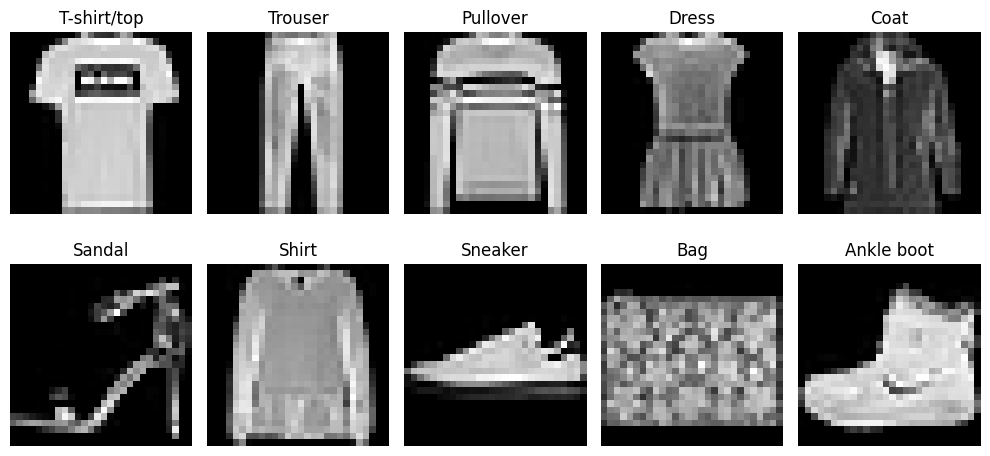

In [5]:
plt.figure(figsize=(10, 5))

# Etiquetas 
categories = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


for i in range(10):
    # Encontrar el primer ejemplo de la categoría actual
    example_index = np.where(y_train == i)[0][0]
    image = X_train[example_index]
    
    # Configurar un subgráfico para cada categoría
    plt.subplot(2, 5, i + 1)  # 2 filas, 5 columnas
    plt.imshow(image, cmap='gray')
    plt.title(categories[i])
    plt.axis('off') 

plt.tight_layout()
plt.show()

In [6]:
@tf.keras.utils.register_keras_serializable()
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [7]:
def plot_mnist_autoencoder(x, x_, y=None, y_=None, cmap='gray', vmin=0, vmax=1):
    """
    Plot the original and reconstructed MNIST images using an autoencoder, including labels.
    
    Parameters:
    ----------
    x : Sequence[np.ndarray]
        Original images.
    x_ : Sequence[np.ndarray]
        Reconstructed images.
    y : Optional[Sequence], optional
        True labels of the images, by default None.
    y_ : Optional[Sequence], optional
        Predicted labels of the images, by default None.
    cmap : str, optional
        Color map for the images, by default 'gray'.
    vmin : float, optional
        Minimum value for normalization, by default 0.
    vmax : float, optional
        Maximum value for normalization, by default 1.
    """
    plt.figure(figsize=(20, 4))
    num_images = len(x)
    
    for i in range(num_images):
        # Display original image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(x[i].reshape(28, 28), cmap=cmap, vmin=vmin, vmax=vmax)
        if y is not None:
            plt.title(f'True: {y[i]}')
        plt.axis('off')
        
        # Display reconstructed image
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(x_[i].reshape(28, 28), cmap=cmap, vmin=vmin, vmax=vmax)
        if y_ is not None:
            color = "red" if y is not None and y[i] != y_[i] else 'green'
            plt.title(f'Pred: {y_[i]}', color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [8]:
def compare_images(original_images, predicted_images, true_labels, label_names, indices, figsize=(10, 5)):
    """
    Función para comparar visualmente imágenes originales con las predicciones, mostrando también las etiquetas verdaderas.
    Args:
    original_images (numpy.array): Array de imágenes originales.
    predicted_images (numpy.array): Array de imágenes reconstruidas por el modelo, con la forma (n_samples, height, width, channels).
    true_labels (numpy.array): Array de etiquetas verdaderas para las imágenes originales.
    label_names (list): Lista de nombres de etiquetas correspondientes a las clases.
    indices (list of int): Lista de índices de las imágenes a comparar.
    figsize (tuple): Tamaño de la figura de matplotlib.
    """
    plt.figure(figsize=figsize)
    num_images = len(indices)

    for i, index in enumerate(indices):
        # Mostrar imagen original
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original_images[index].squeeze(), cmap='gray')
        plt.title(f'Original {index}\nLabel: {label_names[true_labels[index]]}')
        plt.axis('off')

        # Mostrar imagen predicha
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(predicted_images[index].squeeze(), cmap='gray')
        plt.title(f'Reconstrucción {index}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [9]:
# Funciones de pérdida
def reconstruction_loss(y_true, y_pred):
    y_true_flat = tf.keras.backend.flatten(y_true)
    y_pred_flat = tf.keras.backend.flatten(y_pred)
    return tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true_flat, y_pred_flat))

def dkl_loss(y_true, y_pred):
    # y_pred es z_gaussian
    latent_dim = y_pred.shape[1] // 2
    z_mean = y_pred[:, :latent_dim]
    z_log_var = y_pred[:, latent_dim:]
    return -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))

# Criterio de dependencia usando imágenes y etiquetas predichas
def dependency_criterion(images, predicted_labels):
    """
    Calcula el criterio de dependencia entre las imágenes y las etiquetas predichas.
    
    Args:
    images (tensor): Imágenes de entrada del modelo.
    predicted_labels (tensor): Etiquetas predichas por el modelo.
    
    Returns:
    loss (tensor): La pérdida basada en la dependencia entre imágenes y etiquetas.
    """
    # Calcular la media de las imágenes y las etiquetas predichas
    f_mean = K.mean(images, axis=0)
    g_mean = K.mean(predicted_labels, axis=0)
    
    # Centramos las imágenes y las etiquetas predichas
    f_centered = images - f_mean
    g_centered = predicted_labels - g_mean
    
    # Calculamos la covarianza cruzada
    batch_size = tf.cast(tf.shape(images)[0], tf.float32)
    cov_xy = K.dot(K.transpose(f_centered), g_centered) / batch_size
    
    # Maximizar <g, Cxy f>
    loss = -tf.reduce_sum(tf.linalg.diag_part(cov_xy))  # Minimizar el negativo de la traza de la covarianza
    
    return loss


In [10]:
# Definir el modelo
def model_class(input_shape=(28, 28, 1), num_classes=10, latent_dim=128):
    # Encoder
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(6, kernel_size=3, activation='selu',
                               kernel_initializer=tf.keras.initializers.GlorotUniform(seed=12),
                               padding='same', name='conv1')(inputs)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.15)(x)
    x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='selu',
                               kernel_initializer=tf.keras.initializers.GlorotUniform(seed=23),
                               padding='same', name='conv2')(x)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = tf.keras.layers.Conv2D(120, kernel_size=3, activation='selu',
                               kernel_initializer=tf.keras.initializers.GlorotUniform(seed=52),
                               padding='same', name='conv3')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.15)(x)

    z_mean = tf.keras.layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = tf.keras.layers.Dense(latent_dim, name='z_log_var')(x)
    z_gaussian = tf.keras.layers.Concatenate(name='z_gaussian', axis=-1)([z_mean, z_log_var])
    z = Sampling()([z_mean, z_log_var])
    softmax_output = tf.keras.layers.Dense(num_classes, activation='softmax', name='softmax_output')(z)

    # Decoder
    x = tf.keras.layers.Dense(7 * 7 * 16, activation='selu')(z)
    x = tf.keras.layers.Reshape((7, 7, 16))(x)
    x = tf.keras.layers.Conv2DTranspose(16, kernel_size=3, activation='selu',
                                        kernel_initializer=tf.keras.initializers.GlorotUniform(seed=12),
                                        padding='same')(x)
    x = tf.keras.layers.Dropout(0.15)(x)
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    x = tf.keras.layers.Conv2DTranspose(6, kernel_size=3, activation='selu',
                                        kernel_initializer=tf.keras.initializers.GlorotUniform(seed=23),
                                        padding='same', name='conv2Transpose')(x)
    x = tf.keras.layers.Dropout(0.15)(x)
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    reconstruction = tf.keras.layers.Conv2D(input_shape[2], kernel_size=3, padding='same',
                                            activation='sigmoid', name='reconstruction')(x)

    # VAE Model
    vae = tf.keras.models.Model(inputs, [reconstruction, z_gaussian, softmax_output], name='vae')
    return vae

# Construir y compilar el modelo
input_shape = (28, 28, 1)
num_classes = 10
latent_dim = 64
learning_rate = 1e-3

model = model_class(input_shape, num_classes, latent_dim)

# Definir y compilar el modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss={'reconstruction': reconstruction_loss,
                    'z_gaussian': dkl_loss,
                    'softmax_output': dependency_criterion},  # Usar el criterio de dependencia
              loss_weights={'reconstruction': 0.5,
                            'z_gaussian': 0.1,
                            'softmax_output': 0.4},  # Ajusta estos pesos según sea necesario
              metrics={'reconstruction': [reconstruction_loss],
                       'z_gaussian': [dkl_loss],
                       'softmax_output': [dependency_criterion]}
             )

In [11]:
seed = 42
epochs = 100
batch_size = 64
learning_rate =1e-3

In [12]:
history = model.fit(X_train,
                    [X_train, X_train, y_train_one_hot],
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_valid, [X_valid, X_valid, y_valid_one_hot])
                   )

Epoch 1/100


I0000 00:00:1728309049.370771     146 service.cc:145] XLA service 0x7b0a9c0078d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728309049.370817     146 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1728309049.370821     146 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 34/860 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2440 - reconstruction_reconstruction_loss: 0.6191 - softmax_output_dependency_criterion: -0.2469 - z_gaussian_dkl_loss: 0.3323  

I0000 00:00:1728309058.745193     146 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


860/860 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step - loss: 0.0128 - reconstruction_reconstruction_loss: 0.3985 - softmax_output_dependency_criterion: -0.5721 - z_gaussian_dkl_loss: 0.4238 - val_loss: -0.0652 - val_reconstruction_reconstruction_loss: 0.3279 - val_softmax_output_dependency_criterion: -0.6722 - val_z_gaussian_dkl_loss: 0.3926
Epoch 2/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: -0.0658 - reconstruction_reconstruction_loss: 0.3349 - softmax_output_dependency_criterion: -0.6765 - z_gaussian_dkl_loss: 0.3739 - val_loss: -0.0833 - val_reconstruction_reconstruction_loss: 0.3242 - val_softmax_output_dependency_criterion: -0.6983 - val_z_gaussian_dkl_loss: 0.3365
Epoch 3/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: -0.0794 - reconstruction_reconstruction_loss: 0.3285 - softmax_output_dependency_criterion: -0.6974 - z_gaussian_dkl_loss: 0.3527 - val_loss: -0.0886 - val_reconstruction_reconstruction_loss: 0.3174 - val_softmax_output_dependency_criterion: -0.7181 - val_z_ga

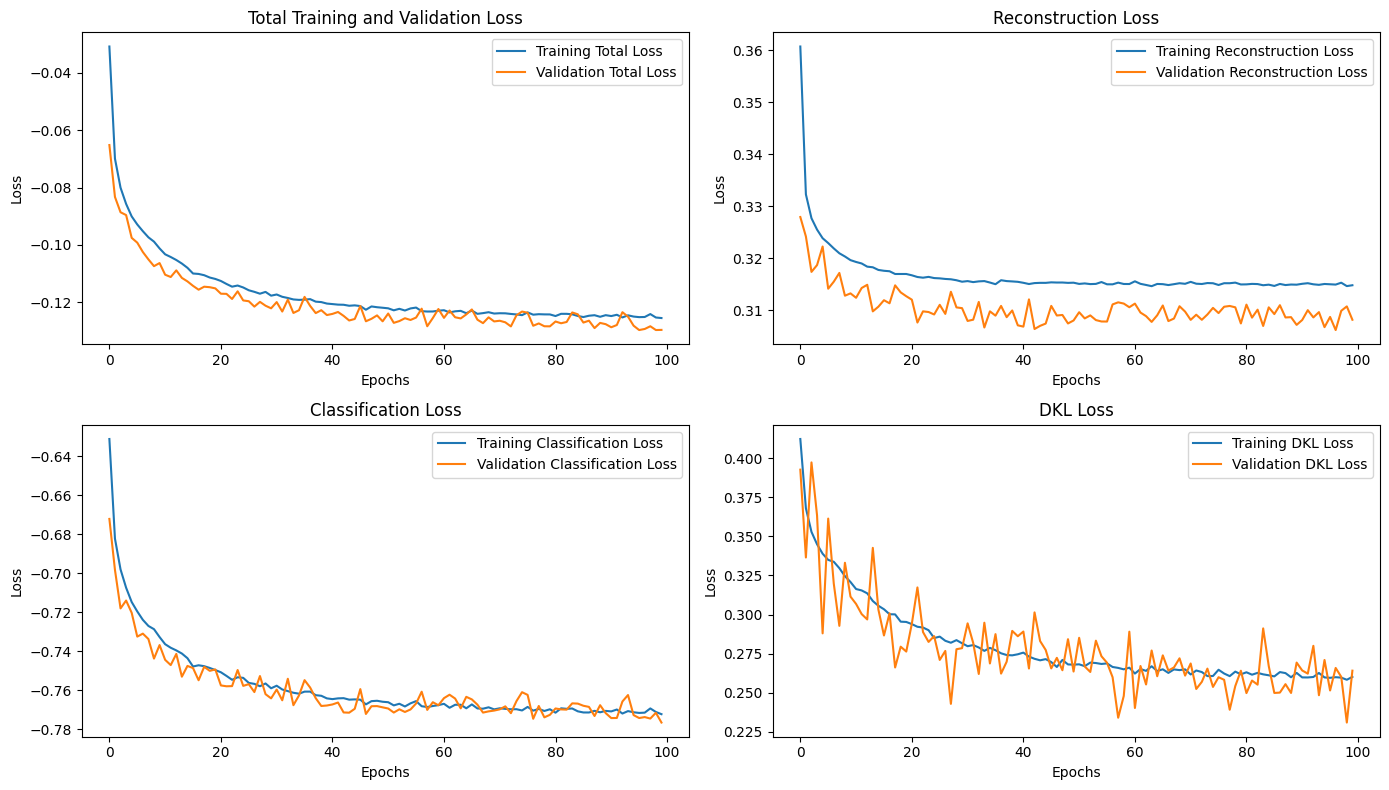

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']
reconstruction_loss = history.history['reconstruction_reconstruction_loss']
val_reconstruction_loss = history.history['val_reconstruction_reconstruction_loss']
classification_loss = history.history['softmax_output_dependency_criterion']
val_classification_loss = history.history['val_softmax_output_dependency_criterion']
dkl_loss = history.history['z_gaussian_dkl_loss']
val_dkl_loss = history.history['val_z_gaussian_dkl_loss']

plt.figure(figsize=(14, 8))

# Gráfico para la pérdida total
plt.subplot(2, 2, 1)
plt.plot(loss, label='Training Total Loss')
plt.plot(val_loss, label='Validation Total Loss')
plt.title('Total Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Gráfico para la pérdida de reconstrucción
plt.subplot(2, 2, 2)
plt.plot(reconstruction_loss, label='Training Reconstruction Loss')
plt.plot(val_reconstruction_loss, label='Validation Reconstruction Loss')
plt.title('Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Gráfico para la pérdida de clasificación
plt.subplot(2, 2, 3)
plt.plot(classification_loss, label='Training Classification Loss')
plt.plot(val_classification_loss, label='Validation Classification Loss')
plt.title('Classification Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Gráfico para la pérdida DKL
plt.subplot(2, 2, 4)
plt.plot(dkl_loss, label='Training DKL Loss')
plt.plot(val_dkl_loss, label='Validation DKL Loss')
plt.title('DKL Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()
plt.show()

In [14]:
X_re = model.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


# **Reconstrucción**

In [15]:
X_re[0].shape

(10000, 28, 28, 1)

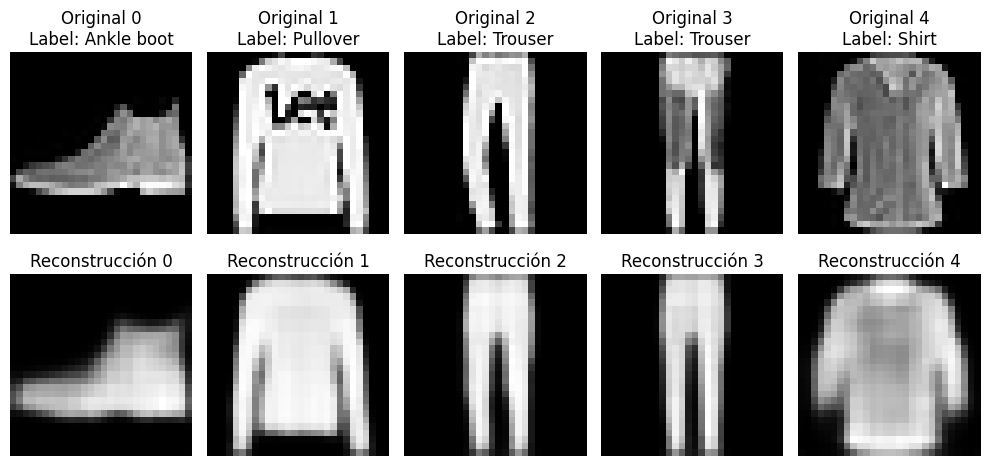

In [16]:
num_samples = 5 
indices_to_compare = [i for i in range(num_samples)] 

# Nombres de etiquetas para el dataset Fashion MNIST
label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

compare_images(X_test, X_re[0], y_test, label_names, indices_to_compare)

# **Espacio Latente**

In [17]:
z=X_re[1].reshape(X_re[1].shape[0],-1)

In [18]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(z)
tsne = TSNE(n_components=2, perplexity= 50)
z_tsne =  MinMaxScaler().fit_transform(tsne.fit_transform(scaled_data))

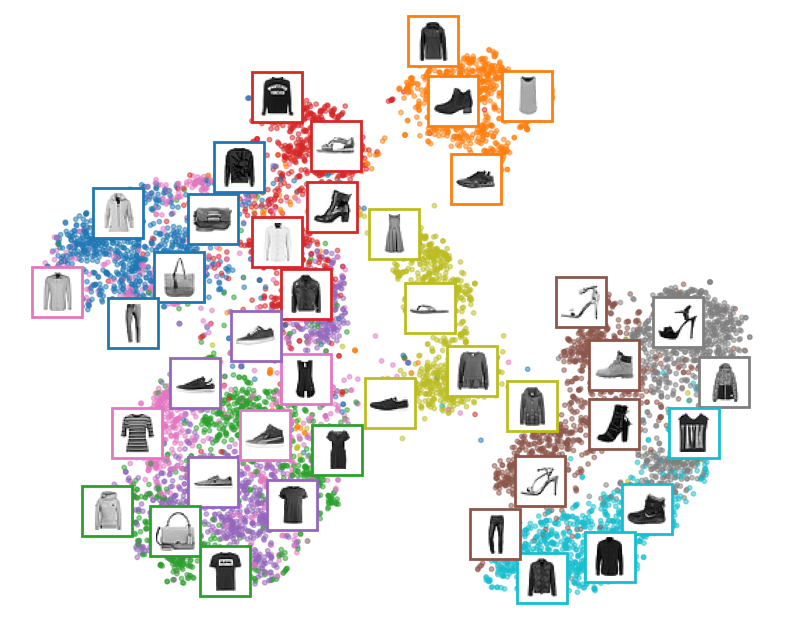

In [19]:
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10

plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=y_test, alpha=0.5, s=10, cmap=cmap)

# Inicializar posiciones de imágenes
image_positions = np.array([[1., 1.]])

# Iterar sobre las posiciones y añadir imágenes
for index, position in enumerate(z_tsne):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.01:  # si está suficientemente lejos de otras imágenes
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_train[index], cmap="binary"),  
            position, bboxprops={"edgecolor": cmap(y_test[index]), "lw": 2})
        plt.gca().add_artist(imagebox)

# Configurar el gráfico y guardar la figura
plt.axis("off")
plt.show()

# **Clasificación**

In [20]:
X_re[2].shape

(10000, 10)

In [21]:
# Obtén las predicciones de clasificación
softmax_output = X_re[2]  
predicted_labels = np.argmax(softmax_output, axis=1)

accuracy = accuracy_score(y_test, predicted_labels)
print("Accuracy:", accuracy)
print(classification_report(y_test, predicted_labels))

Accuracy: 0.8837
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1000
           1       0.99      0.96      0.98      1000
           2       0.78      0.84      0.81      1000
           3       0.90      0.86      0.88      1000
           4       0.76      0.87      0.81      1000
           5       0.97      0.96      0.96      1000
           6       0.79      0.56      0.65      1000
           7       0.93      0.97      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.98      0.95      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



# **Recostrucción y Clasificación**

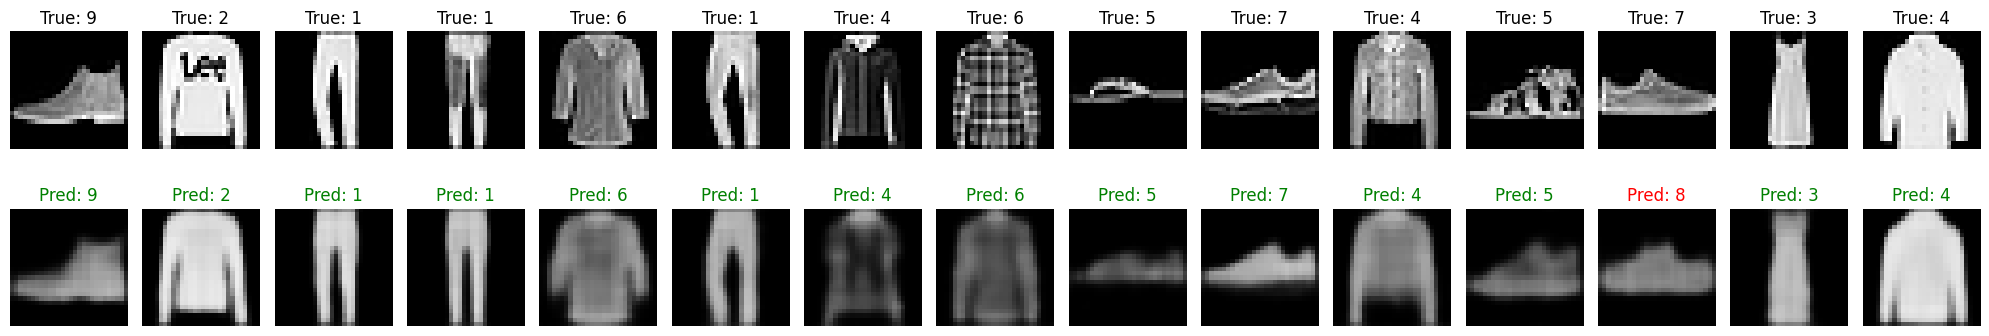

In [22]:
N = 15
predicted_labels = np.argmax(X_re[2][:N], axis=1) 
plot_mnist_autoencoder(
    X_test[:N], 
    X_re[0][:N], 
    y_test[:N],  
    predicted_labels  
)

# **CAMS**

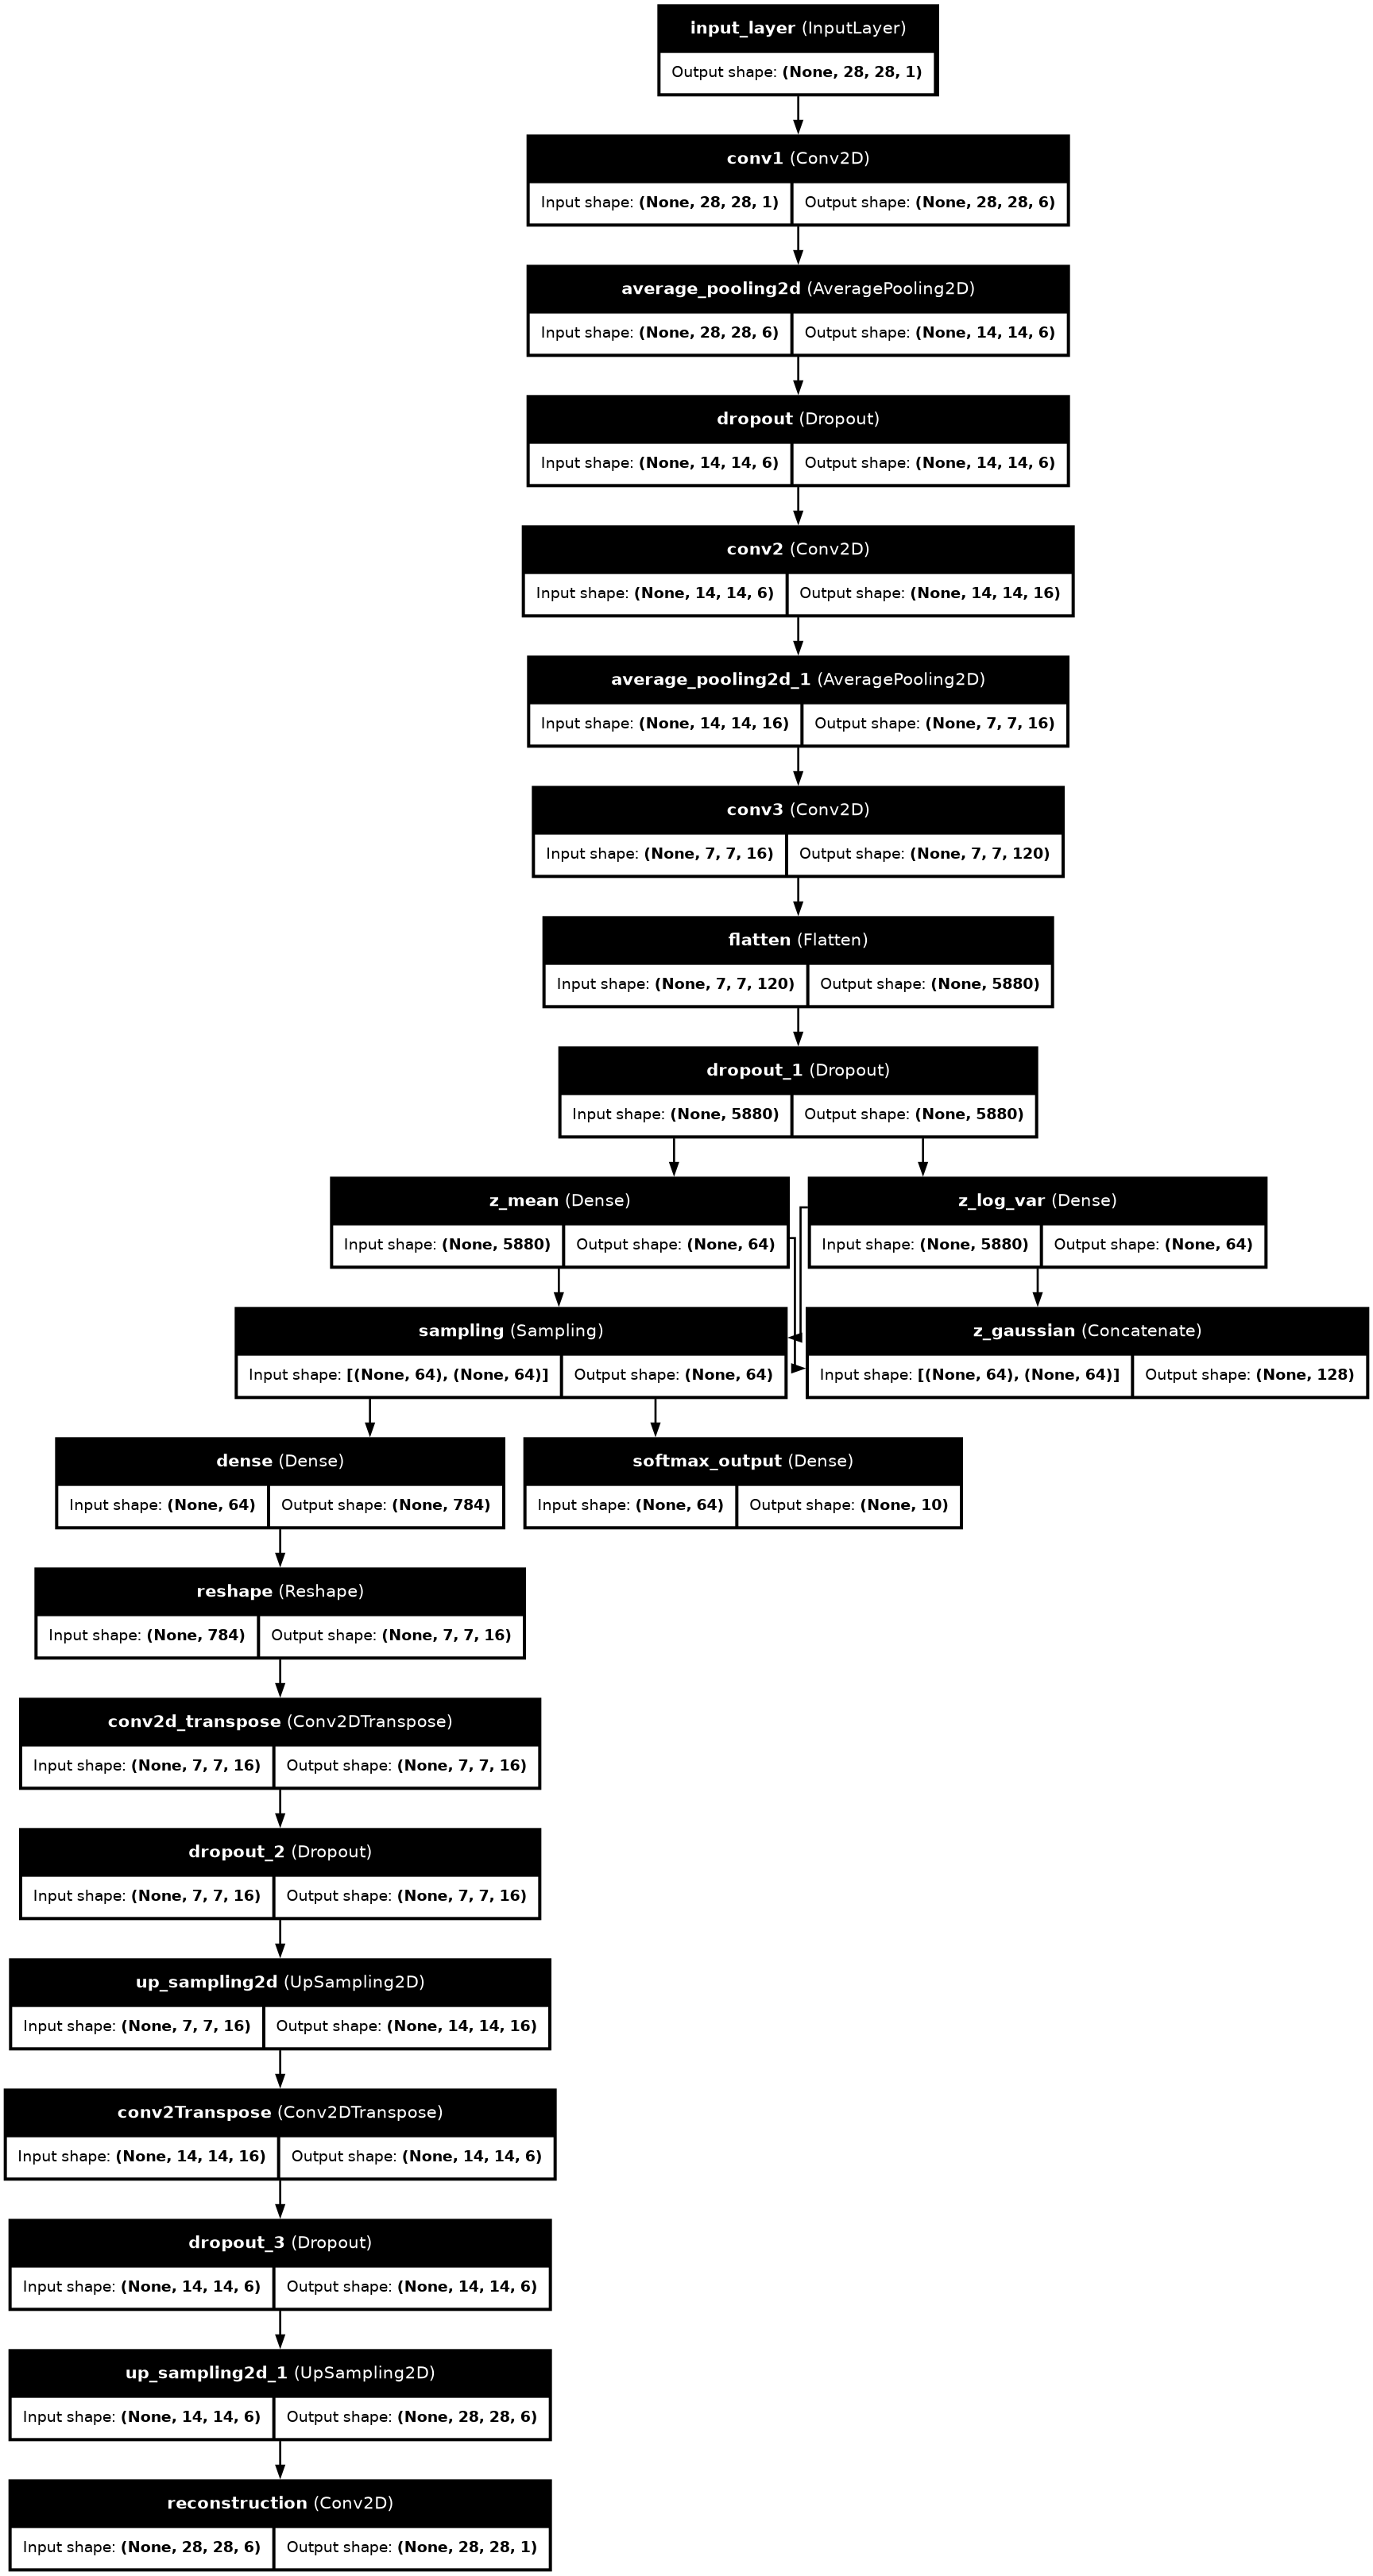

In [23]:
tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes=True, dpi=96)

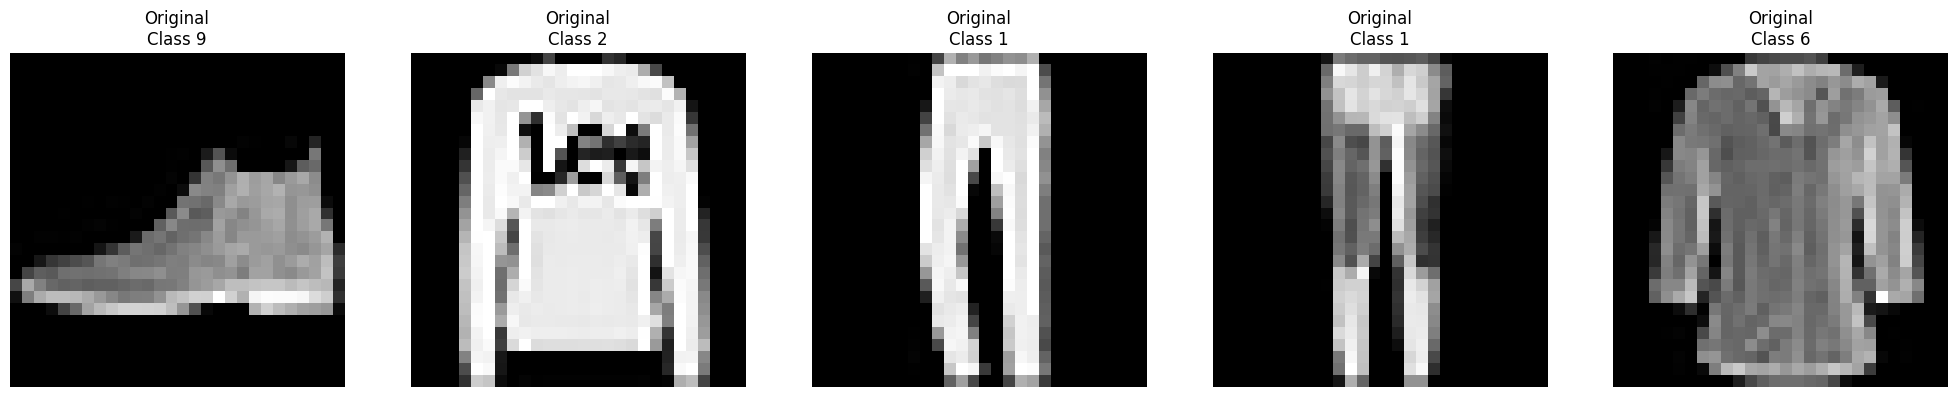

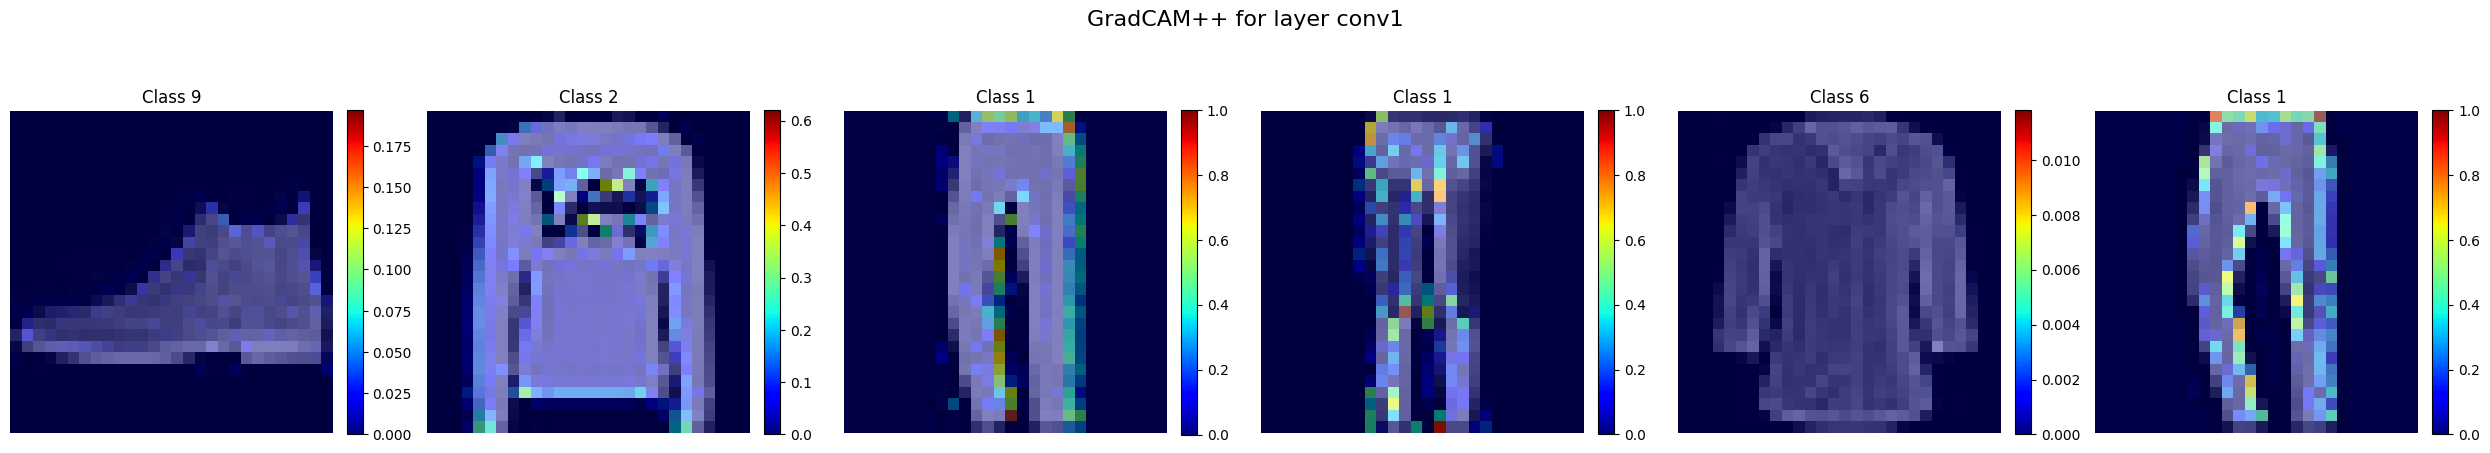

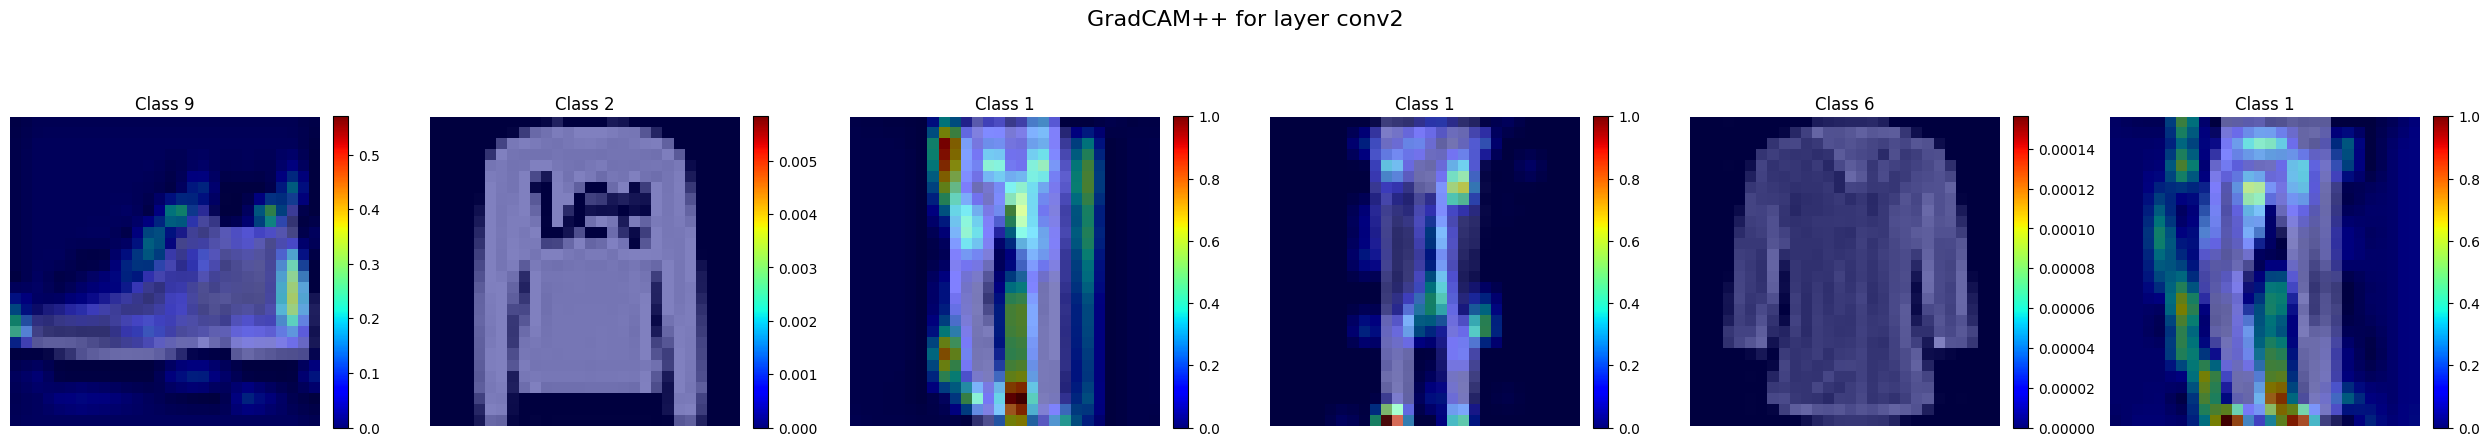

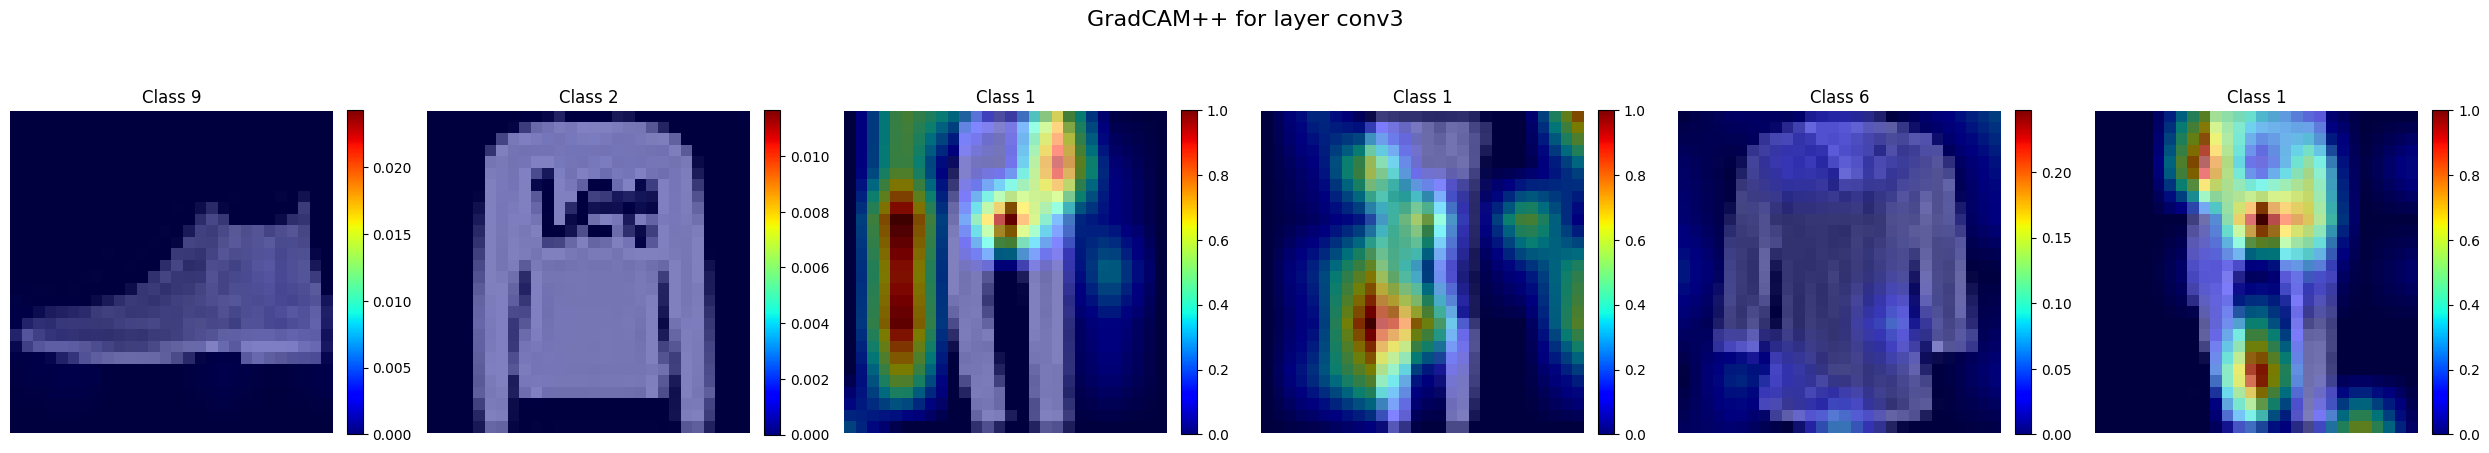

In [24]:
layers = ['conv1', 'conv2', 'conv3']

# Visualizar la imagen original con mayor tamaño
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

num_images = 5
images = X_test[:num_images].reshape(-1, 28, 28, 1)
labels = y_test[:num_images]

for i in range(5):
    image = images[i]
    label = labels[i]
    ax_img = axes[i]
    ax_img.imshow(image.squeeze(), cmap='gray')
    ax_img.axis('off')
    ax_img.set_title(f'Original\nClass {label}')

for layer in layers:
    # Crear el modelo que solo tenga la salida del clasificador
    model_for_gradcam = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer('softmax_output').output)

    # Crear el objeto GradCAM++
    gradcam = GradcamPlusPlus(model_for_gradcam, model_modifier=ReplaceToLinear(), clone=True)

    # Seleccionar las primeras 6 imágenes del conjunto de prueba
    num_images = 6
    images = X_test[:num_images].reshape(-1, 28, 28, 1)
    labels = y_test[:num_images]

    # Crear una figura con subplots
    fig, axes = plt.subplots(1, 6, figsize=(25, 5))
    fig.suptitle(f'GradCAM++ for layer {layer}', fontsize=16)  # Añadir título con el nombre de la capa

    for i, (image, label) in enumerate(zip(images, labels)):
        # Generar el CAM con GradCAM++ usando la capa actual
        cam = gradcam(CategoricalScore(1), image.reshape(1, 28, 28, 1), penultimate_layer=layer)

        # Visualizar el mapa de calor superpuesto en la imagen original
        heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
        ax_heatmap = axes[i]
        ax_heatmap.imshow(image.squeeze(), cmap='gray')
        ax_heatmap.imshow(heatmap, cmap='jet', alpha=0.5)
        ax_heatmap.axis('off')
        ax_heatmap.set_title(f'Class {label}')
        
        # Añadir la barra de colores (color bar)
        norm = plt.Normalize(vmin=cam[0].min(), vmax=cam[0].max())
        sm = plt.cm.ScalarMappable(cmap='jet', norm=norm)
        sm.set_array([])
        fig.colorbar(sm, ax=ax_heatmap, orientation="vertical", fraction=0.046, pad=0.04)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajustar layout para el título
    plt.show()
